<a id='top-page'></a>
# <img src="../images/PCAfold-logo.svg" style="height:100px"> Demo for nonlinear regression

In this tutorial, we present the nonlinear regression utilities from the ``analysis`` module.

## Nonlinear regression

A synthetic data set is created and we perform nonlinear regression using kernel regression:

- [**Generating a synthetic data set**](#data-generation)
- [**Kernel regression**](#kernel-regression)
- [**Nonlinear regression assessment**](#assessment)

***

**Should plots be saved?**

In [1]:
save_plots = False

***

We import the necessary modules:

In [2]:
from PCAfold import preprocess
from PCAfold import reduction
from PCAfold import analysis
import numpy as np

and we set some initial parameters:

In [3]:
save_filename = None

<a id='data-generation'></a>
***

## Generating a synthetic data set

[**↑ Go to the top**](#top-page)

We begin by generating a synthetic data set with two independent variables, $x$ and $y$, and one dependent variable, $\phi$, that we will nonlinearly regress using kernel regression.

Generate independent variables $x$ and $y$ from a uniform grid:

In [4]:
n_points = 100

x = np.tile(np.linspace(0,100,n_points), n_points)
y = np.zeros((n_points,1))
for i in range(1,n_points):
    y = np.vstack((y, np.ones((n_points,1))*i))
y = y.ravel()

xy = np.hstack((x[:,None],y[:,None]))

(n_observations, _) = np.shape(xy)

Generate a dependent variable $\phi$ as a linear function of $x$:

In [5]:
phi = np.zeros((n_points*n_points,1))

for observation, x_value in enumerate(x):

    phi[observation] = x_value

Visualize the generated data set:

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


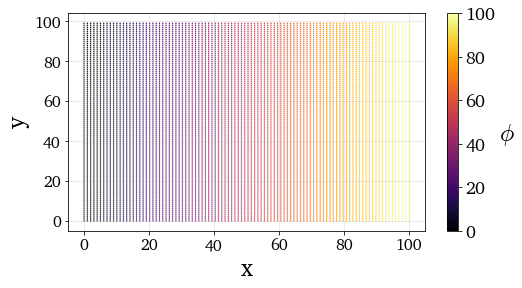

In [6]:
if save_plots: save_filename = '../images/tutorial-regression-data-set.svg'
plt = reduction.plot_2d_manifold(x, y, color=phi, x_label='x', y_label='y', colorbar_label='$\phi$', color_map='inferno', figure_size=(8,4), save_filename=save_filename)

<a id='kernel-regression'></a>
***

## Kernel regression

[**↑ Go to the top**](#top-page)

We first generate train and test samples using the `DataSampler` class:

In [7]:
train_perc = 80
random_seed = 100

sample_random = preprocess.DataSampler(np.zeros((n_observations,)), random_seed=random_seed, verbose=False)
(idx_train, idx_test) = sample_random.random(train_perc, test_selection_option=1)

xy_train = xy[idx_train,:]
xy_test = xy[idx_test,:]

phi_train = phi[idx_train]
phi_test = phi[idx_test]

Specify the bandwidth for the Nadaraya-Watson kernel:

In [8]:
bandwidth = 10

Fit the kernel regression model with train data:

In [9]:
model = analysis.KReg(xy_train, phi_train)

Predict the test data:

In [10]:
phi_test_predicted = model.predict(xy_test, bandwidth=bandwidth)

Predict all data:

In [11]:
phi_predicted = model.predict(xy, bandwidth=bandwidth)

<a id='assessment'></a>
***

## Nonlinear regression assessment

[**↑ Go to the top**](#top-page)

In this section we will perform few assessments of the quality of the nonlinear regression.

We begin by visualizing the regressed (predicted) dependent variable $\phi$. This can be done either in 2D:

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


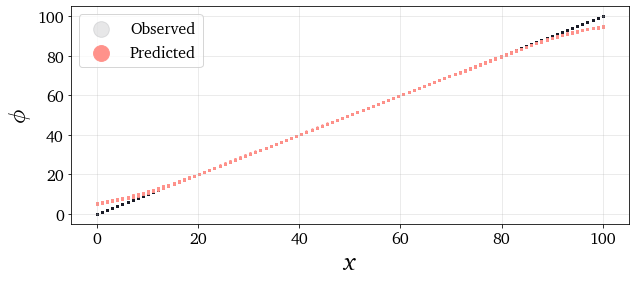

In [12]:
if save_plots: save_filename = '../images/tutorial-regression-result-2d.svg'
plt = analysis.plot_2d_regression(x, phi, phi_predicted, x_label='$x$', y_label='$\phi$', figure_size=(10,4), save_filename=save_filename)

or in 3D:

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


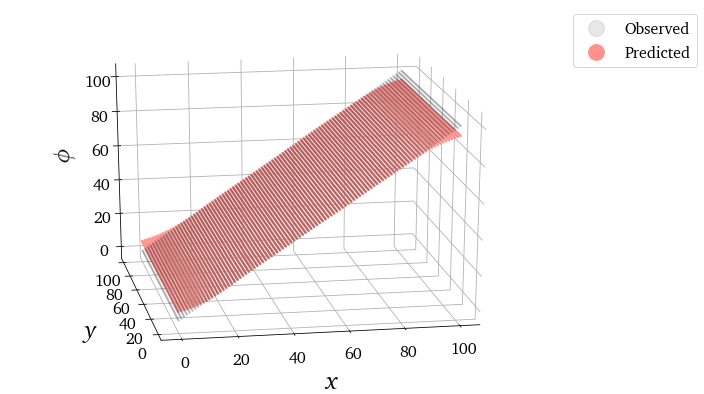

In [13]:
if save_plots: save_filename = '../images/tutorial-regression-result.svg'
plt = analysis.plot_3d_regression(x, y, phi, phi_predicted, elev=20, azim=-100, x_label='$x$', y_label='$y$', z_label='$\phi$', figure_size=(10,7), save_filename=save_filename)

We can then compute the coefficient of determination, $R^2$, values for the test data and entire data: 

In [14]:
r2_test = analysis.r2value(phi_test, phi_test_predicted)
r2_all = analysis.r2value(phi, phi_predicted)

print('All R2:\t\t' + str(round(r2_all, 6)) + '\nTest R2:\t' + str(round(r2_test, 6)))

All R2:		0.997378
Test R2:	0.997366


In addition to a single value of $R^2$ for the entire data set, we can also compute stratified $R^2$ values. This allows us to observe how kernel regression performed in each strata of the dependent variable $\phi$. We will compute the stratified $R^2$ in 20 bins of $\phi$:

In [15]:
n_bins = 20
use_global_mean = False
verbose = True

(r2_in_bins, bins_borders) = analysis.stratified_r2(phi, phi_predicted, n_bins=n_bins, use_global_mean=use_global_mean, verbose=verbose)

Bin	1	| size	 500	| R2	-8.083554
Bin	2	| size	 500	| R2	-1.012664
Bin	3	| size	 500	| R2	0.74316
Bin	4	| size	 500	| R2	0.979256
Bin	5	| size	 500	| R2	0.995444
Bin	6	| size	 500	| R2	0.992669
Bin	7	| size	 500	| R2	0.993084
Bin	8	| size	 500	| R2	0.995499
Bin	9	| size	 500	| R2	0.994835
Bin	10	| size	 500	| R2	0.994202
Bin	11	| size	 500	| R2	0.997531
Bin	12	| size	 500	| R2	0.995191
Bin	13	| size	 500	| R2	0.988946
Bin	14	| size	 500	| R2	0.993118
Bin	15	| size	 500	| R2	0.995184
Bin	16	| size	 500	| R2	0.980076
Bin	17	| size	 500	| R2	0.955785
Bin	18	| size	 500	| R2	0.776274
Bin	19	| size	 500	| R2	-0.711611
Bin	20	| size	 500	| R2	-7.413988


Finally, we can plot the stratified $R^2$ values across bins centers:

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


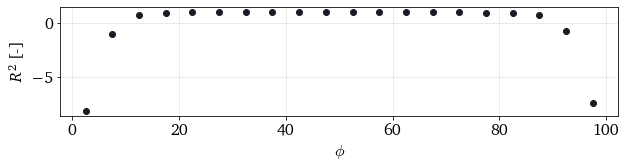

In [16]:
if save_plots: save_filename = '../images/tutorial-regression-stratified-r2.svg'
plt = analysis.plot_stratified_r2(r2_in_bins, bins_borders, variable_name='$\phi$', figure_size=(10,2), save_filename=save_filename)

This last plot lets us see that kernel regression performed very well in the
middle range of the dependent variable values but very poorly at both edges of that range.
This is consistent with what we have seen in a 3D plot
that visualized the regression result.

***